# Explainable AI

## Worksheet 1: SHAP (SHapley Additive exPlanations)
---


---
### What is SHAP?

SHAP (SHapley Additive exPlanations) is a method to explain individual classification predictions. SHAP is based on the game theoretically optimal Shapley Values. For further information on the topic and definitions, we refer students to the lecture slides and recordings for the XAI technique (SHAP).



Useful sources:

*   https://christophm.github.io/interpretable-ml-book/shap.html#shap-summary-plot
*   https://github.com/slundberg/shap



---

---

### Today's problem

During our first workshop, we will try to find the linkage between characteristics of students and their performance of school. This dataset comes from [UCI](https://archive.ics.uci.edu/ml/datasets/Student+Performance) and it measures the achievements of teenagers in their Mathematics and Portuguese language exams.

In this tutorial, we will split students into two pools - a "pass" pool (final Mathematics exam score equal to or above 10) and "fail" group (final Mathematics exam score below 10). We will do some quick data cleaning, followed by applying a popular, and rather opaque, classification algorithm called LGBM. Finally, we will apply a tree explainer based on SHAP values devised by [Lundberg et al. (2020)](https://www.nature.com/articles/s42256-019-0138-9.epdf?shared_access_token=RCYPTVkiECUmc0CccSMgXtRgN0jAjWel9jnR3ZoTv0O81kV8DqPb2VXSseRmof0Pl8YSOZy4FHz5vMc3xsxcX6uT10EzEoWo7B-nZQAHJJvBYhQJTT1LnJmpsa48nlgUWrMkThFrEIvZstjQ7Xdc5g%3D%3D).

---


## Example


### Importing libraries & data
As usual, we will start by importing the libraries. Google Colab has many libraries preinstalled, but not all. For this worksheet, we will need to install shap first. `pip` is a python libraries installing tool.

In [1]:
!pip install shap

Now, we can import the extra functionalities from relevant Python libraries.

In [2]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
from google.colab import drive
from hyperopt import hp, tpe
from hyperopt import space_eval
from hyperopt.fmin import fmin

To load the data, we need to connect Google colab to our google drive.

In [3]:
# Connect to the Google Drive.
drive.mount('/content/drive',  force_remount=True)

Mounted at /content/drive


In [4]:
# Import the data from Google Drive.
df = pd.read_csv("/content/drive/My Drive/XAI-Worksheets/student-mat.csv", sep=';')

### Data processing

Similar to the previous worksheet, the first step is exploring what we have and adjusting the dataset for our needs. The workflow is following:

*   Visually checking what we have in the DataFrame
*   Assessing and treating potential missingness
*   Creating new labels

Let's start by displaying the first few lines of the DataFrame.


In [5]:
# Get first 5 rows from the top of the table.
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


We will need the names of the features later, so we store them separately.



In [6]:
df_col_used = df.columns.tolist()
df_col_used

['school',
 'sex',
 'age',
 'address',
 'famsize',
 'Pstatus',
 'Medu',
 'Fedu',
 'Mjob',
 'Fjob',
 'reason',
 'guardian',
 'traveltime',
 'studytime',
 'failures',
 'schoolsup',
 'famsup',
 'paid',
 'activities',
 'nursery',
 'higher',
 'internet',
 'romantic',
 'famrel',
 'freetime',
 'goout',
 'Dalc',
 'Walc',
 'health',
 'absences',
 'G1',
 'G2',
 'G3']

Now, let's see what the types of the features are.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

Everything looks really good! The data types are appropriate (categorical data is treated as "object", with numerical values being "int64") and there are no missing values (we have 395 rows in the table and 395 non-null values in each column).

We can now focus on preparing the data for modelling.

If you look at the last column in the DataFrame, we see that the grades are ranging from 0 to 20. We just want to predict whether a student has passed (G3 >= 10) or failed (G3 < 10). So we can fix it by creating a new grade list from G3.

In [8]:
labels = [0 if x  < 10 else 1 for x in df["G3"]]

Now that we have stored the labels separately, we can drop the grades columns from the table.

In [9]:
df = df.drop(columns = ["G1", "G2", "G3"])

Before using LGBM, we need to adjust the categorical columns slightly. Specifically, we need to change their data type in Pandas from "object" to "categorical", otherwise, the algorithm will not recognise them (you can find more information about it in the documentation of LGBM).

In [10]:
cats_features = df.select_dtypes('object').columns.tolist()
for c in cats_features:
    df[c] = df[c].astype('category')

Now that all the data is prepared, we can split our data into training (80% of the data) and testing (20%). We use the parameter `random_state=42` to make sure that all students have the same random splitting.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.2, random_state=42)

And we repeat the process to split our training data further into training and validation data. Both will be used for fitting LGBM - the training set will be the estimation basis while the validation set will be used for the early stopping algorithm to prevent overfitting with gradient boosting.

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Our data is prepared, now we can start with the modelling.

### Modelling

Having adjusted the data, let us apply the LGBM algorithm, get some initial results and tune its hyperparameters. We put all the hyperparameters into a dictionary, which we can then pass onto our model. We are not aiming here for any brilliant results - simply trying the model out first!

In [19]:
params = {
    'max_depth': 6,
    'min_child_weight': 0,
    'learning_rate': 0.5,  # Ensure this is a float
    'colsample_bytree': 0.75,  # Ensure this is a float
    'subsample': 1,
    'reg_lambda': 1,
    'n_estimators': 150,
    'objective': 'binary',
    'verbose': -1  # Setting verbose here
}

# Create the LGBMClassifier model with the specified parameters
lgb_model = lgb.LGBMClassifier(**params)

# Fitting the model on the training set and controlling for overfitting with early stopping
lgb_fitted = lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[lgb.early_stopping(50)]  # Using early_stopping as a callback
)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.697265



Now, let's assess the model's performance. We can use the simple function below on the test data to check how predictive the classifier is.



Confusion matrix:


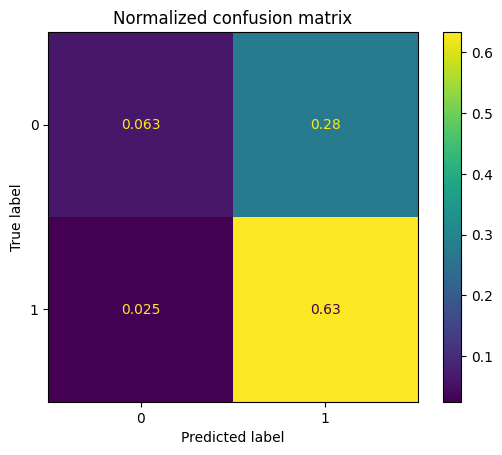

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.19      0.29        27
           1       0.69      0.96      0.81        52

    accuracy                           0.70        79
   macro avg       0.70      0.57      0.55        79
weighted avg       0.70      0.70      0.63        79



Done!


In [20]:
def model_assessment(model, X, y):

    # Get the confusion matrix.
    print("Confusion matrix:")
    disp = ConfusionMatrixDisplay.from_estimator(model, X, y,  normalize='all')

    disp.ax_.set_title("Normalized confusion matrix")

    plt.show()

    # Produce a classification report.
    print("Classification Report:")
    pred = model.predict(X)
    print(classification_report(y, pred))
    print('\n')
    print("Done!")

model_assessment(lgb_fitted, X_test, y_test)

Let us ignore the outputs for now.

So far, we have managed to prepare our data and build the first version of the model. The next step is tuning the hyperparameters in attempt to get the most performant model. We have prepared a function to tune the parameters below.

In [21]:
def objective(params):

    # Here is a list of hyperparameters that will be considered when optimising.
    # Each of those parameters will either be an integer (if int() wrapping is used in the dictionary below, e.g.'max_depth')
    # or a floating point value (as indicated by {:.3f}).
    # This is not an exhaustive list of what could be tuned but these parameters are usually considered key in practice.
    params = {
        'max_depth': int(params['max_depth']),
        'num_leaves': int(params['num_leaves']),
        'min_child_weight': '{:.3f}'.format(params['min_child_weight']),
        'colsample_bytree': '{:.3f}'.format(params['colsample_bytree']),
        'subsample': '{:.3f}'.format(params['subsample']),
        'n_estimators': int(params['n_estimators']),
        'verbose': -1
    }

    # Here is the model that will be using the hyperparameters above.
    clf = lgb.LGBMClassifier(objective = 'binary',
                             **params)

    # Here is the scoring function - we will be ensuring that the "score" variable takes an as small as possible value.
    # To be precise, we are minimising the mean log loss generated by the model in the process of cross-validation on the training set.
    # We have chosen mean log loss as the score given it is one of the typical accuracy measures used in hyperoptimisation for
    # binary classification problems.
    score = cross_val_score(clf,
                            X_train,
                            y_train,
                            scoring="neg_log_loss",
                            cv = StratifiedKFold(shuffle=True, random_state=42)).mean()*(-1)

    # The log loss is found for each set of parameters.
    print("Log loss of {:.3f} for the selected parameters {}".format(score, params))
    return score

# These are the distributions from which sample values of hyperparameters will be generated for optimisations.
# Each iteration (their number is define by max_evals below) will be based on a different set.
space = {
    'max_depth':        hp.choice('max_depth', np.arange(2, 63, 1, dtype=int)),
    'num_leaves':       hp.choice('num_leaves', np.arange(7, 4000, 20, dtype=int)),
    'min_child_weight': hp.choice('min_child_weight', np.arange(0.01, 0.5, 0.05)),
    'colsample_bytree': hp.choice('colsample_bytree', np.arange(0.4, 0.9, 0.05)),
    'subsample':        hp.uniform('subsample', 0.4, 1),
    'n_estimators':     hp.choice('n_estimators', np.arange(50, 5000, 50, dtype=int)),
}

# The command below runs the process.
optimal = fmin(fn=objective,
            space = space,
            algo = tpe.suggest,
            max_evals = 100)

# Let us extract the optimal values.
optimal = space_eval(space, optimal)
print("Optimal parameters: {}".format(optimal))

Log loss of 1.498 for the selected parameters {'max_depth': 19, 'num_leaves': 1587, 'min_child_weight': '0.210', 'colsample_bytree': '0.500', 'subsample': '0.708', 'n_estimators': 4300, 'verbose': -1}
Log loss of 1.685 for the selected parameters {'max_depth': 34, 'num_leaves': 3447, 'min_child_weight': '0.060', 'colsample_bytree': '0.400', 'subsample': '0.651', 'n_estimators': 4450, 'verbose': -1}
Log loss of 1.504 for the selected parameters {'max_depth': 26, 'num_leaves': 2407, 'min_child_weight': '0.160', 'colsample_bytree': '0.550', 'subsample': '0.548', 'n_estimators': 2550, 'verbose': -1}
Log loss of 1.598 for the selected parameters {'max_depth': 5, 'num_leaves': 347, 'min_child_weight': '0.060', 'colsample_bytree': '0.400', 'subsample': '0.471', 'n_estimators': 1350, 'verbose': -1}
Log loss of 1.402 for the selected parameters {'max_depth': 32, 'num_leaves': 667, 'min_child_weight': '0.310', 'colsample_bytree': '0.450', 'subsample': '0.647', 'n_estimators': 4150, 'verbose': -1

Let's use the optimal parameters to refit the model and assess the new model.

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[9]	valid_0's binary_logloss: 0.677248
Confusion matrix:


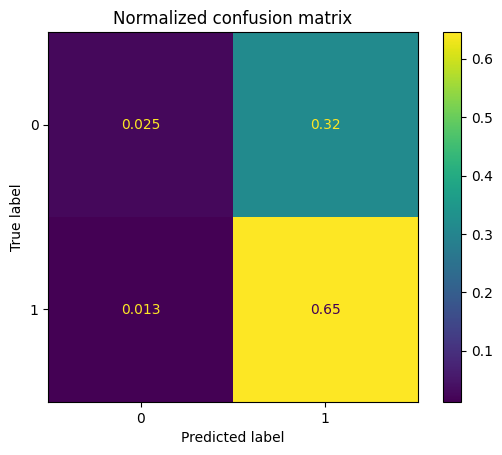

Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.07      0.13        27
           1       0.67      0.98      0.80        52

    accuracy                           0.67        79
   macro avg       0.67      0.53      0.47        79
weighted avg       0.67      0.67      0.57        79



Done!


In [26]:
optimal['verbose'] = -1
lgb_model = lgb.LGBMClassifier(objective = 'binary', **optimal)
lgb_fitted = lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[lgb.early_stopping(50)]  # Using early_stopping as a callback
)


model_assessment(lgb_fitted, X_test, y_test)

*NOTE: Your model performance may return different values.*

It turns out that in its current form our model is leaning strongly towards predicting every student to pass the exam. 92% of those who do pass the exam are correctly identified as such, but also 85% of those who actually fail are predicted to pass the exam.

#### **Question 1:**
How would you interpret 50% *precision* in the table above?

#### **Question 2:**
Which metric from the above do you think would be of the most interest to a stakeholder interested in a model that aims to predict students' performance?





### Application of SHAP

Using SHAP, we will try to check

-   which features drive the global behaviour of the model,
-   what factors have the most influence on the classification of individual students, and
-   what the dependencies between features are.

Firstly, we need to get the Shapley values:

In [27]:
explainer = shap.TreeExplainer(lgb_fitted)
shap_values = explainer.shap_values(X_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


Now, we can produce global summary plots from the perspective of class 1.

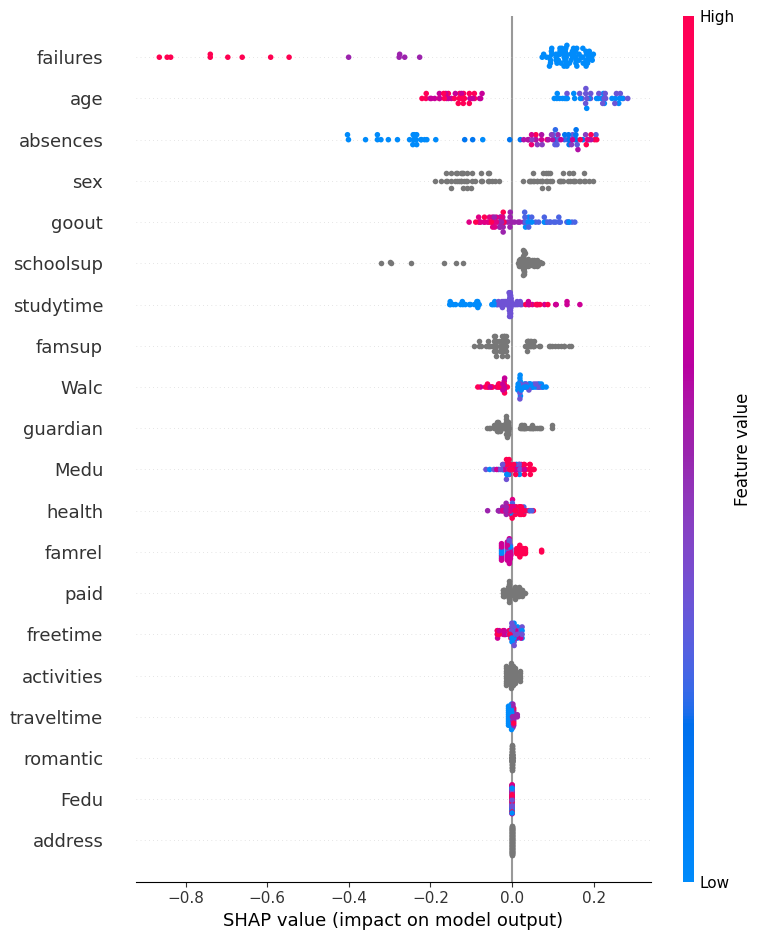

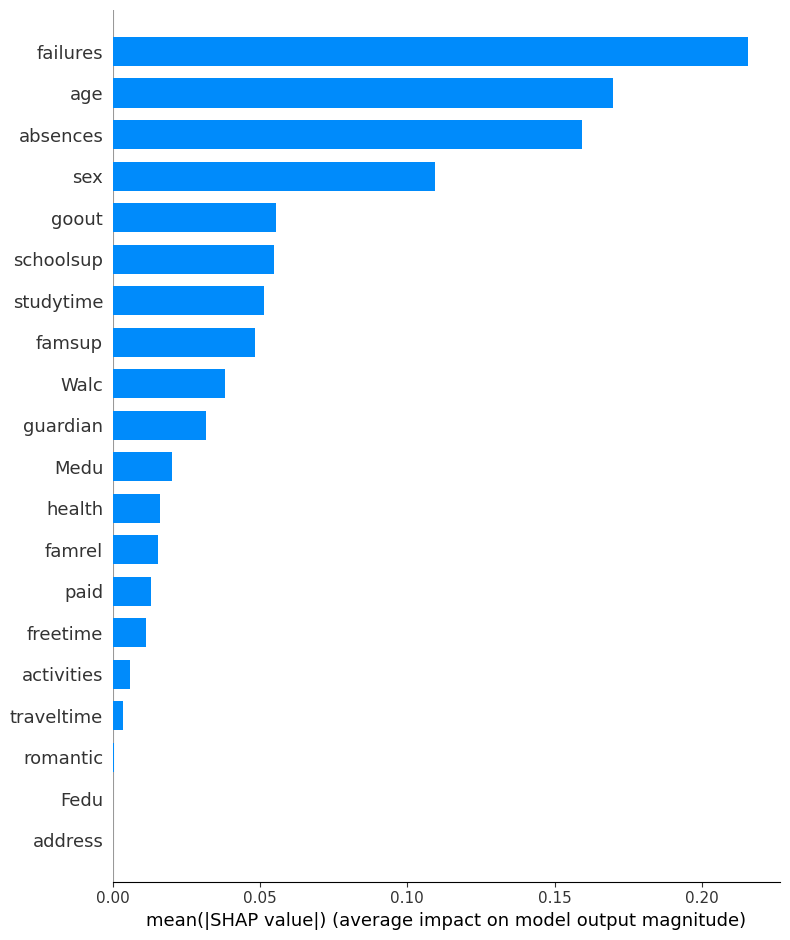

In [28]:
shap.summary_plot(shap_values[1], X_test)
shap.summary_plot(shap_values[1], X_test, plot_type="bar")

#### **Question 3:**
Generate the same plots for instances in class 0. What is the link between these graphs and what has been generated for class 1?

#### **Question 4:**
What are the 5 most important features which are driving this model's decisions?

#### **Question 5:**
How would you interpret the horizontal axis of the first summary plot above? What does a SHAP value of -1.5 mean?

#### **Question 6:**
Can we express SHAP values in terms of probability? Justify your answer.

After assesing the general importance of variables, let us focus on individual predictions for single observations. Drilling down into the details they can help us validate our model and find any hidden biases.

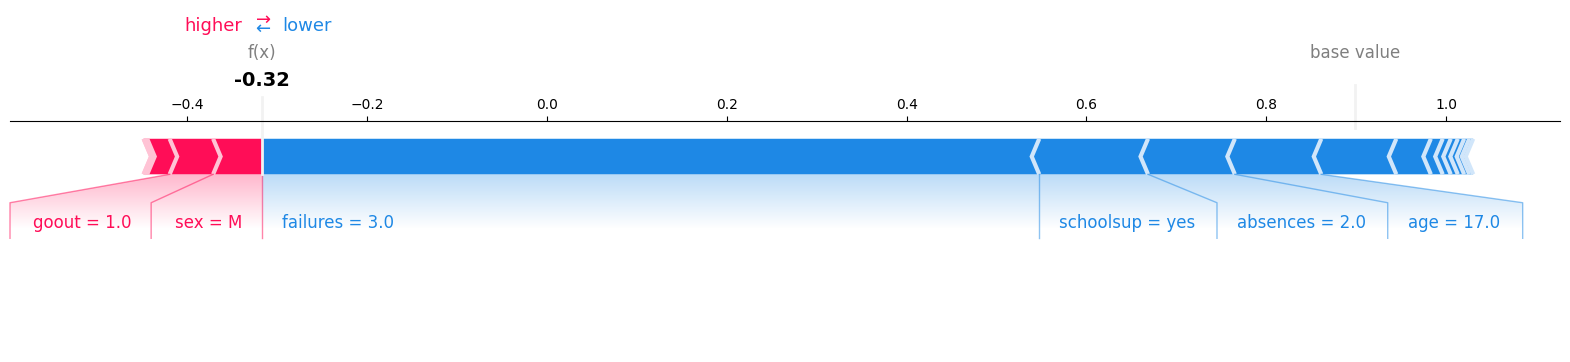

In [35]:
## Next, let us pick 3 random students from the test set and apply local predictions for them.
# Student 1.
import matplotlib
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], X_test.iloc[0,:], matplotlib=matplotlib)

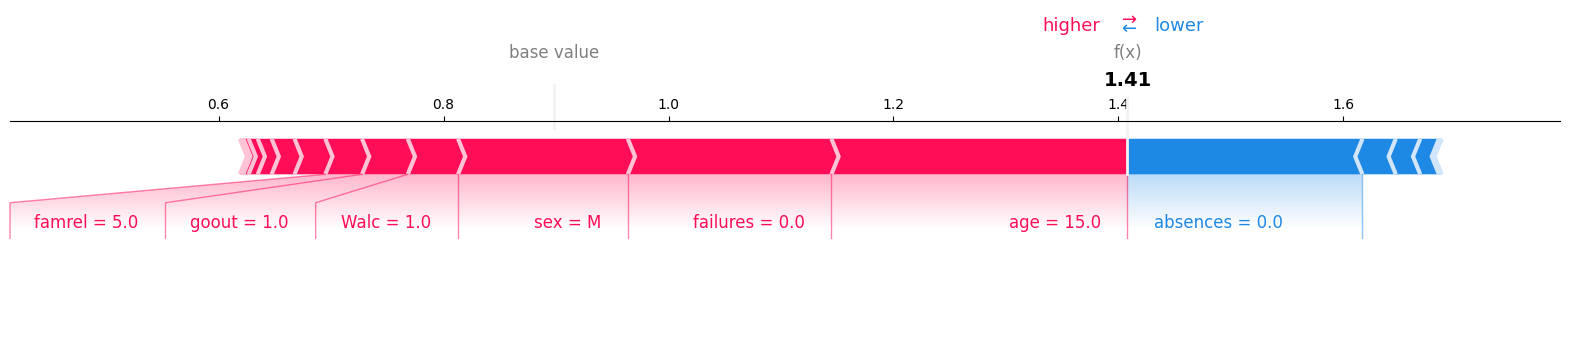

In [37]:
# Student 2.
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][10], X_test.iloc[10,:], matplotlib=matplotlib)

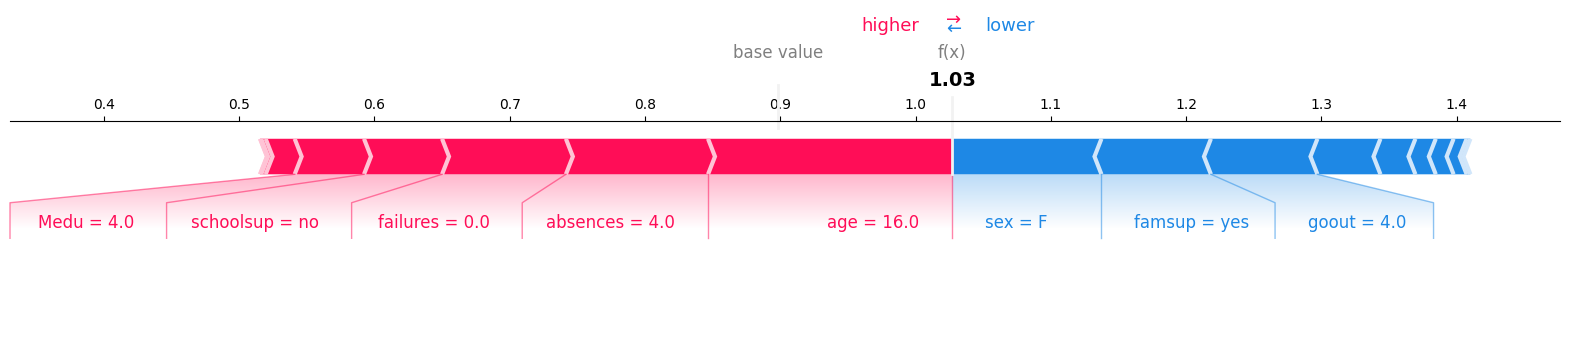

In [38]:
# Student 3.
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][20], X_test.iloc[20,:], matplotlib=matplotlib)

#### **Question 7:**
According to these plots, which student is most likely to fail (assuming our model is appropriate)?

#### **Question 8:**
Are there any features which are important from the perspective of predictions on the local level for these 3 students and which could indicate some fairness issues?

#### **Question 9:**
Produce a local plot as above for another student (feel free to select your own observation). How different is it from the global picture?

These figures can be also presented in a form of waterfall/decision plots as below. Below, we give an example of a decision plot for the 21st student in our test set. It aims to display the same information as the last force plot from above.

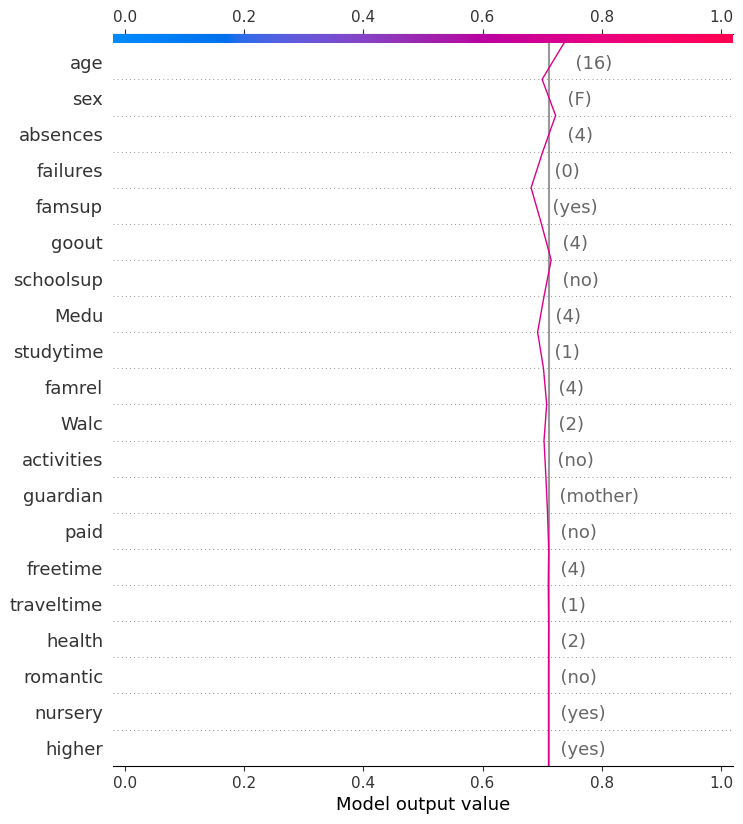

In [39]:
shap.initjs()
shap.decision_plot(explainer.expected_value[1], shap_values[1][20], X_test.iloc[20,:], link='logit')

#### **Question 10:**
What does the horizontal spectrum on the top of the graph show? What do those values mean?

*(Hint: look at https://slundberg.github.io/shap/notebooks/plots/decision_plot.html)*


---

## Assignment 1


1.   Use the public dataset introduced in this tutorial and apply an XGBoost model. Your outcome variable will be Portugese language scores pooled into class 0 and 1 in the same way as in this notebook (feel free to skip any hyperparmeter tuning operations). Make predictions on your test set and produce a set of measures that describe the model's performance.
2.   Using SHAP summary plots, what are the 5 most important features in the model?
3.   Create a decision plot for all observations and all features in your test set, highlight misclassified observations and include interaction values.
4.   Make SHAP dependence plots of the 4 most important features. Use sex as the feature possibly influencing SHAP outputs. This done by setting the ```interaction_index``` as "sex".
5.   In the light of the plots from 3 and 4, discuss whether the interaction effect between sex and other features can meaningfully impact decisions of your model.
6.   Discuss how various SHAP-based graphs can be used in the process of model validation.
7.   Write a paragraph for a non-technical audience explaining how your model makes decisions based on SHAP outputs. Ensure the text is clear of jargon!

